In [49]:
from get_plot_functions import *

import os
from fuzzywuzzy import process
import pandas as pd

In [50]:
# Function to normalize text
def normalize_text(text):
    return str(text).lower().strip()

# Variables

In [74]:
input_folder = 'data/gisaid_data_26_12_2023'

# Load data

In [52]:
############################################
## gisaid data
############################################
df_gisaid = pd.DataFrame({})
for file in os.listdir(input_folder):
    df_ = pd.read_csv(f'{input_folder}/{file}', sep='\t')
    df_gisaid = pd.concat([df_gisaid, df_])

df_gisaid['count_'] = 1
df_gisaid['division_exposure'] = df_gisaid.division_exposure.replace({'Distrito Capital de Bogota' : 'Bogota',
                                      'Distrito Capital' : 'Bogota',
                                      'San Andres islas' : 'San andres'})
df_gisaid.loc[df_gisaid.location.isna(), 'location'] = df_gisaid.loc[df_gisaid.location.isna(), 'division']

df_gisaid['location']  = df_gisaid['location'] .apply(normalize_text)
df_gisaid['location'] = df_gisaid.location.replace({'distrito capital' : 'bogota'})

In [55]:
###########################################
## GEo info Colombia
###########################################
df_p = pd.read_csv('/zine/HPC02S1/ex-dveloza/AGORA/apps/synthetic_populations/data/processed_data/geodata/geoinfo_municipios_colombia.csv')
df_p['NOM_DEPART'] = df_p.NOM_DEPART.replace({'SATA FE DE BOGOTÁ D.C.' : 'BOGOTÁ',
                        'ARCHIPIÉLAGO DE SAN ANDRÉS, PROVIDENCIA Y SANTA CATALINA' : 'San Andres y Providencia'})

In [58]:
places_df = df_gisaid[['division', 'location']].drop_duplicates()
places_df.columns = ['Departamento', 'Place']

# Normalize the text in these columns
places_df['Departamento'] = places_df['Departamento'].apply(normalize_text)
places_df['Place'] = places_df['Place'].apply(normalize_text)

# Normalize the department and municipality names in df_p
df_p['NOM_MUNICI'] = df_p['NOM_MUNICI'].apply(normalize_text)
df_p['NOM_DEPART'] = df_p['NOM_DEPART'].apply(normalize_text)

def classify_place(row):
    depart, place = row['Departamento'], row['Place']
    if pd.isna(place):
        return 'Unknown', None, None

    # Attempt to match the department
    best_match_depart, score_depart = process.extractOne(depart, df_p['NOM_DEPART'].unique())
    
    # If a matching department is found, look for the best matching municipality within that department
    if score_depart > 80:
        df_filtered = df_p[df_p['NOM_DEPART'] == best_match_depart]
        best_match_munic, score_munic = process.extractOne(place, df_filtered['NOM_MUNICI'].unique())
        
        # Return results with best matching department and municipality
        return 'Municipio', best_match_munic, best_match_depart
    else:
        # Attempt to match the place to all municipalities and get the best match
        best_match_munic, score_munic = process.extractOne(place, df_p['NOM_MUNICI'].unique())
        
        # If the score for the best matching municipality is strong enough, find its corresponding department
        if score_munic > 80:
            # Find the department for the best matching municipality
            best_dept_for_munic = df_p[df_p['NOM_MUNICI'] == best_match_munic]['NOM_DEPART'].iloc[0]
            return 'Municipio', best_match_munic, best_dept_for_munic
        else:
            return 'Unknown', None, None

In [59]:
# # Apply the function to each row
places_df[['Classification', 'Best Match Munic', 'Best Match Depart']] = places_df.apply(classify_place, axis=1, result_type='expand')

In [60]:
df_matching = places_df[places_df.Classification != 'Unknown']

In [61]:
df_conflicting = places_df[places_df.Classification == 'Unknown'][['Departamento','Place']]
df_conflicting.columns = ['Place', 'Departamento']
df_conflicting[['Classification', 'Best Match Munic', 'Best Match Depart']] = df_conflicting.apply(classify_place, axis=1, result_type='expand')
df_conflicting = df_conflicting.rename(columns={'Place':'Departamento','Departamento':'Place'})

In [62]:
df_conflicting[df_conflicting.Classification == 'Unknown']

,Departamento,Place,Classification,Best Match Munic,Best Match Depart


In [64]:
df_complete_match = pd.concat([df_matching, df_conflicting])

df = df_complete_match.merge(df_p, left_on=['Best Match Depart','Best Match Munic'], right_on=['NOM_DEPART','NOM_MUNICI'], how='left').drop_duplicates().rename(columns={'Departamento':'division', 'Place':'location'})#[['Place','COD_MUN','NOM_MUNICI','COD_DEPTO','NOM_DEPART']]
del df['Classification']
del df['Best Match Munic']
del df['Best Match Depart']
# conflicting_rows = df.groupby(by=['NOM_MUNICI','NOM_DEPART']).filter(lambda x: len(x) > 1)

In [66]:
df_gisaid['division'] = df_gisaid.division.apply(normalize_text)
df_gisaid['location'] = df_gisaid.location.apply(normalize_text)

df_clean = df_gisaid.merge(df, on=['division', 'location'], how='left')
df_clean['date'] = pd.to_datetime(df_clean['date'], format='mixed')

# Variant prevalence

In [145]:
time_period = '7D'
periods = 80
bar_width = 5
fontsize = 11
fontsize_dates = 10

In [160]:
keywords_alpha =   ["B.1.1.7", "^Q."]
keywords_gamma =   ["P.1", "^P.1."]
keywords_mu =      ["^B.1.621", "^B.1.621.1", "^B.1.621.2", "^BB.1", "^BB.2"]
keywords_delta =   ["B.1.617.2", "^AY."]
# keywords_omicron = ["B.1.1.529", "BA.1", "^BA.1.", "^BA.1.1", "^BA.1.1", "BA.2","^BA.2.", "BA.3", "BA.4", "BA.5", "B.2.12.1", "BQ.1", "^BQ.1.", "^XBB"]
keywords_omicron =    ["B.1.1.529", "BA.1", "^BA.1.", "^BA.1.1", "^BA.1.1", "BA.2","^BA.2.", "BA.3", "BA.4", "BA.5", "B.2.12.1"]
keywords_omicronBAX = ["BQ.1", "^BQ.1.", "^XBB"]

In [161]:
dicc_variants = {'Alpha':   keywords_alpha,
                 'Gamma':   keywords_gamma, 
                 'Mu':      keywords_mu, 
                 'Delta':   keywords_delta, 
                 'Omicron': keywords_omicron,
                 'OmicronBAX': keywords_omicronBAX}

In [173]:
for cod_dept in df_clean.COD_DEPTO.unique():
    df_ = df_clean[df_clean.COD_DEPTO == cod_dept].set_index('date')
    df_['count_'] = 1


    df_formated_info    = get_formated_count_dataframes(df_, dicc_variants, time_period, omit_other=False)
    df_formated_info    = df_formated_info[df_formated_info.columns[:-1]]
    row_sums            = df_formated_info.sum(axis=1)
    df_normalized       = df_formated_info.div(row_sums, axis=0)
    df_normalized.fillna(0, inplace=True)

    df_normalized['week'] = pd.to_datetime(df_normalized.index).isocalendar().week

    nom_departamento = df_.NOM_DEPART.unique()[0].upper()
    df_normalized[df_normalized[df_normalized.columns[:-1]].sum(axis=1) > 0].to_csv(f'../../input_files/dominance_data/{cod_dept}_dominance_data.csv')

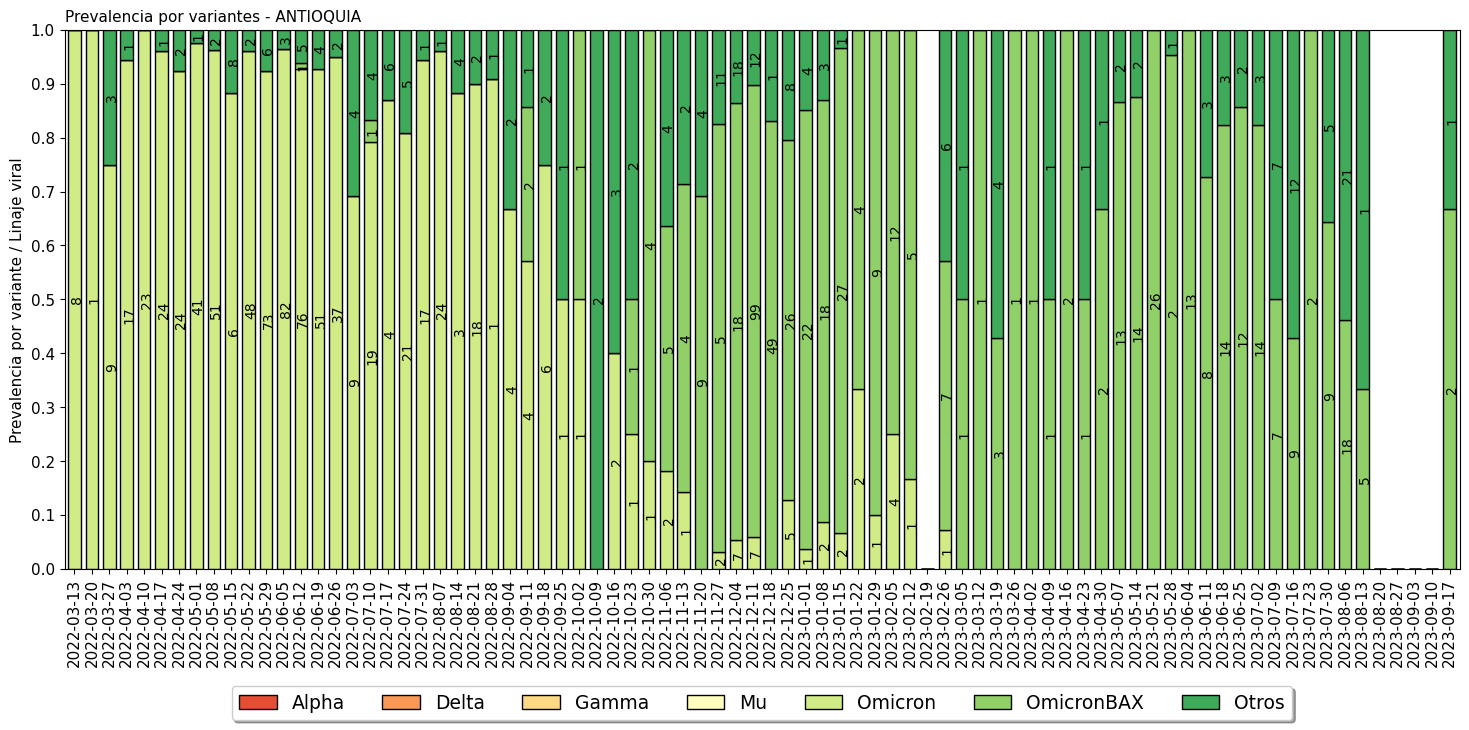

In [162]:
df_counts = get_formated_count_dataframes(df_, dicc_variants, time_period, omit_other=False)
get_GISAID_bar_plot(df_counts, time_period, periods, bar_width, fontsize, fontsize_dates, title=f"Prevalencia por variantes - {nom_departamento}")

# Omicron linages prevalences

In [94]:
periods = 35
bar_width = 10

In [95]:
keywords_omicron_BA_1 = ["BA.1", "^BA.1."]
keywords_omicron_BA_1_1 = ["^BA.1.1"]
keywords_omicron_BA_2 = ["BA.2","^BA.2."]
keywords_omicron_BA_3 = ["BA.3"]
keywords_omicron_BA_4 = ["BA.4"]
keywords_omicron_BA_5 = ["BA.5"]
keywords_omicron_B_2_12_1 = ["B.2.12.1"]
keywords_omicron_BQ_1 = ["BQ.1", "^BQ.1."]
keywords_omicron_XBB = ["^XBB"]

In [96]:
dicc_variants = {'BA.1':      keywords_omicron_BA_1,
                 'BA.1.1':    keywords_omicron_BA_1_1, 
                 'BA.2':      keywords_omicron_BA_2, 
                 'BA.3':      keywords_omicron_BA_3, 
                 'BA.4':      keywords_omicron_BA_4,
                 'BA.5':      keywords_omicron_BA_5,
                 'B.2.12.1':  keywords_omicron_B_2_12_1,
                 'BQ.1':      keywords_omicron_BQ_1,
                 'XBB':       keywords_omicron_XBB}

In [97]:
df_counts = get_formated_count_dataframes(df_, dicc_variants, time_period, omit_other=True)

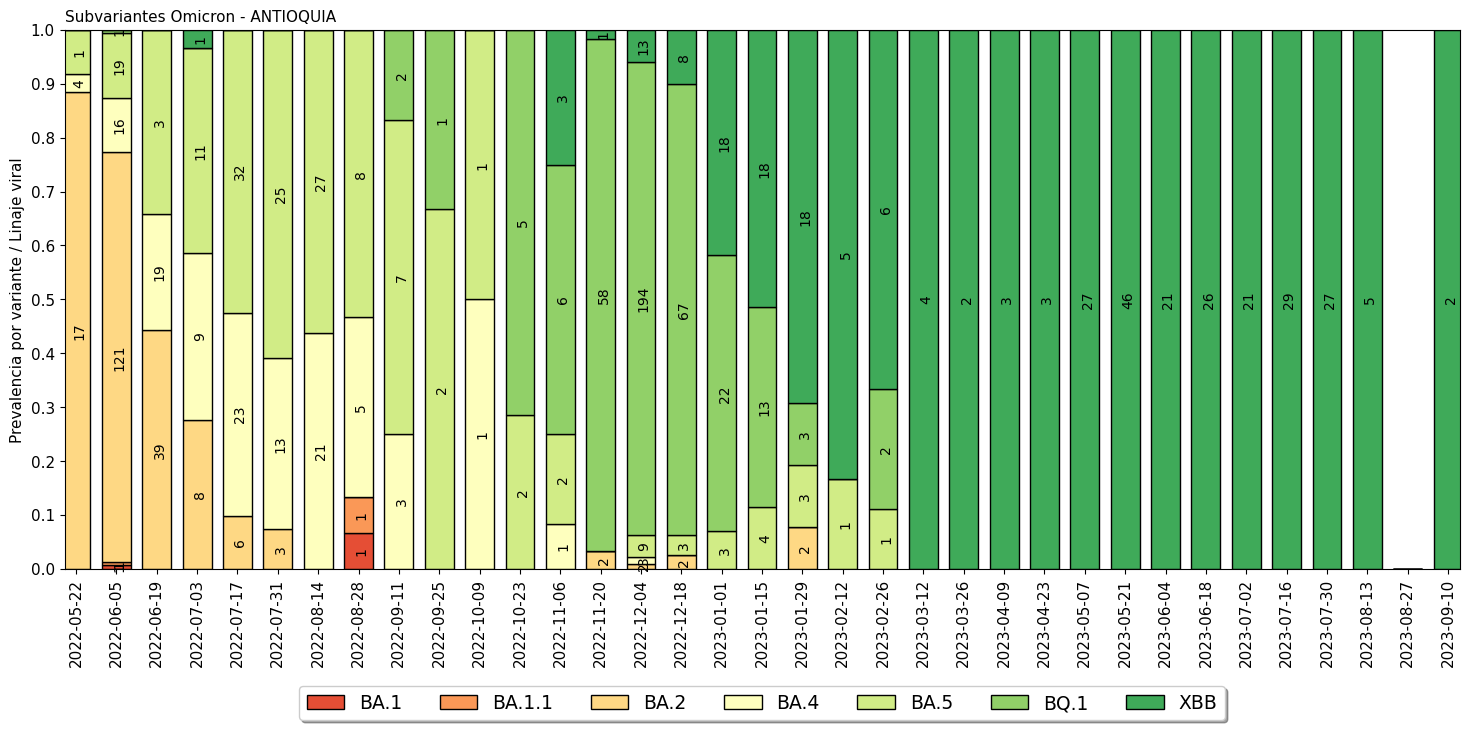

In [98]:
get_GISAID_bar_plot(df_counts, time_period, periods, bar_width, fontsize, fontsize_dates, title=f"Subvariantes Omicron - {nom_departamento}")